In [1]:
from fenics import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, 
               "eliminate_zeros": True, 
               "precompute_basis_const": True, 
               "precompute_ip_const": True}

# Static hyperelasticity #
Hyperelasticity: internal energy only depends on state.

$$
\begin{align}
- \text{div} P = B & \text{ in } \Omega \\
u = g & \text{ on } \Gamma_D \\
P\cdot n = T & \text{ on } \Gamma_N 
\end{align}
$$

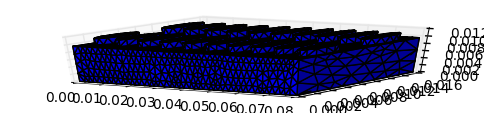

In [2]:
g = Constant(9.81)
T = Constant(5000.)

# Material properties
rho = Constant(1450.)
# E = 0.0065e9
# nu = 0.41*1e9

mesh = Mesh("./lego_beam.xml")
plot(mesh)

V = VectorFunctionSpace(mesh, "Lagrange", 1)

# Mark boundary subdomians
class BoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] < 0.1*0.001 + DOLFIN_EPS
    
class BoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] > 10*0.008 - 0.1*0.001 - DOLFIN_EPS
    
# set boundary markers
boundary_markers = FacetFunction('size_t', mesh)
boundaries = FacetFunction("size_t", mesh)
boundaries.set_all(0)
left = BoundaryLeft()
left.mark(boundary_markers, 1)
right = BoundaryRight()
right.mark(boundary_markers, 2)

# Define measure ds to apply markers
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

# Define boundary conditions on the domain V
c = Constant((0., 0., 0.))
bcl = DirichletBC(V, c, left)
bc = [bcl]

# Define loads:
B = Constant((0.0, 0.0, -Constant(g*rho)))  # Body force per unit volume
T = Constant((0.0, 0.0, -Constant(T)))  # Traction force on the boundary

# Solve using strain energy #

In [3]:
# Define functions
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration

# Kinematics
I = Identity(len(u))             # Identity tensor
F = I + grad(u)                  # Deformation gradient
C = F.T*F                        # Right Cauchy-Green tensor
E = (C - I)/2

mu = 0.00230 * 1e9
lmbd = 0.0105 * 1e9

# Stored strain energy density
E = variable(E)
W =  lmbd/2 * (tr(E))**2 + mu * tr(E*E)

Pi = W*dx - dot(B, u)*dx - dot(T, u)*ds(2)
dPi = derivative(Pi, u, v)
ddPi = derivative(dPi, u, du)
solve(dPi == 0., u, bc, J=ddPi)

# Analyze results:
z_vals = assemble(u[2]*dx)
vol2 = assemble(1.0*dx(mesh))
print("average z-displacement: ", z_vals / vol2)

('average z-displacement: ', -0.005208646473438716)


# Solve using PK-tensor #

In [4]:
# Define functions
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration

# Kinematics
I = Identity(len(u))             # Identity tensor
F = I + grad(u)                  # Deformation gradient
C = F.T*F                        # Right Cauchy-Green tensor
E = (C - I)/2

mu = 0.00230 * 1e9
lmbd = 0.0105 * 1e9

# Stored strain energy density
E = variable(E)
W =  lmbd/2 * (tr(E))**2 + mu * tr(E*E)

S = diff(W, E)
P = F*S

Fu = inner(P, grad(v))*dx - dot(B, v)*dx - dot(T, v)*ds(2)
solve(Fu == 0, u, bc)

# Analyze results:
z_vals = assemble(u[2]*dx)
vol = assemble(1.0*dx(mesh))
print("average z-displacement: ", z_vals / vol)

('average z-displacement: ', -0.005208646473438716)


In [5]:
z_vals / vol2

-0.005208646473438716

In [6]:
F_out = File('NL_pde/displacement.pvd')
F_out << u